## 1. Read and explore data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate import prepare_areal_shapefile
from pyinterpolate import get_points_within_area
from pyinterpolate import fit_semivariance
from pyinterpolate import ArealKriging

In [3]:
areal_data_file = './input_data/merged_data_and_shp_2180/covid_wrzesien_2180.shp'
point_data_file = './input_data/population_data/population_centroids_poland.shp'

areal_id_column_name = 'ID'
areal_val_column_name = '14.09'
points_val_column_name = 'TOT'


areal_data = prepare_areal_shapefile(areal_data_file,
                                     id_column_name=areal_id_column_name,
                                     value_column_name=areal_val_column_name)
point_data = get_points_within_area(areal_data_file, point_data_file, areal_id_col_name=areal_id_column_name,
                                   points_val_col_name=points_val_column_name)


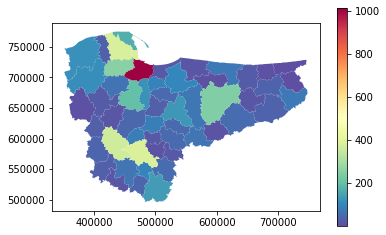

In [5]:
# Lets take a look into a map of areal counts

gdf = gpd.read_file(areal_data_file)
gdf.plot(column='14.09', cmap='Spectral_r', legend=True)

## 2. Load semivariogram model

In this step we load regularized semivariogram from the tutorial Semivariogram Regularization (Intermediate). You can always perform semivariogram regulariztion along with the Poisson Kriging but it is a very long process and it is more convenient to separate those two steps.


In [6]:
semivariogram = fit_semivariance.TheoreticalSemivariogram()  # Create TheoreticalSemivariogram object
semivariogram.import_model('./output_data/regularized_model.csv')  # Load regularized semivariogram


## 3. Perform Area to Point smoothing of areal data.

The process of map smoothing is straightforward. We need to initialize Kriging model then invoke method regularize_data. This method takes three parameters:

=> number of observations (the most important parameter - how many neighbors are affecting your area of analysis), => minimum search radius (minimum search radius for analysis from your area of interest, if there are less areas than number of observations then the new, next closest neighbors are included in the analysis), => data_crs with default EPSG 4326.

!!! czemu EPSG 4326 jest deafult jeśli używamy EPSG:2180, a dane o kształcie powiatów to EPSG:4258

Method returns GeoDataFrame with points and predicted values. It iteratively re-calculates each area risk and returns predictions per point. In Area to Area Kriging those predictions where aggregated, now we leave them and use them as a smooth map of areal risk.


In [8]:
number_of_obs = 8
#!!! znowu to, że jest 8 jest z dupy co nie?
radius = 80000

kriging_model = ArealKriging(semivariogram_model=semivariogram,
    known_areas=areal_data,
    known_areas_points=point_data,
    kriging_type='atp')


In [10]:
smoothed_area = kriging_model.regularize_data(number_of_neighbours=number_of_obs,
                                             s_radius=radius,
                                             data_crs=gdf.crs)
#!!! liczy się chwile, laptop tak zaczął się chłodzić jakby miał odlecieć
#!!! nie rozumiem, czemu to nam wypluwa to co chcemy
#!!! bo odpalamy reguralyzacje na kriging_model, który ma atp
#!!! po co podajemy data_crs=gdf.crs, czy dlatego, żeby dobrze liczył radius

## 4. Visualize data

The last step is data visualization. We use choropleth map from the GeoPandas package, but you can store smoothed map to shapefile of points and process it in a different place or with specific software (in our idea the best for it is QGIS).

In [11]:
smoothed_area.head()

,id,geometry,estimated value,estimated prediction error,rmse
0,1107,POINT (440124.682 702592.439),0.000000,142.037373,109.947269
1,1107,POINT (445085.474 701970.577),0.000000,140.619190,109.947269
2,1107,POINT (424611.772 699504.653),4.358300,65.688111,109.947269
3,1107,POINT (429572.456 698882.496),1.948354,97.199312,109.947269
4,1107,POINT (434533.195 698260.475),41.147982,116.624861,109.947269


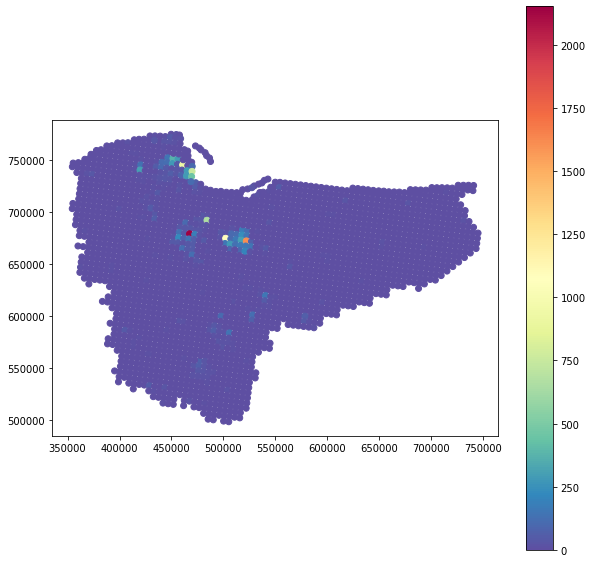

In [12]:
smoothed_area.plot(column='estimated value', cmap='Spectral_r', legend=True, figsize=(10, 10))
#!!! to wygląda turbo podejrzanie, tczew najgorszym miastem z całej północy polski? 